In [1]:
from graphviz import Digraph
import math

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label ='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward # we are storing the function not calling it 
        return out

    def __radd__(self, other): # other + self
        return self + other
    
    def neg(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*self.data ** (other-1) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): #slef/other
        return self * other**-1
    
    def __rmul__(self, other): #other * self
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad #multiply with out.grad just for the chain it
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [40]:
test = Value(2.0)
test2 = Value(2.0)

test-4

value(data=-2.0)

In [3]:

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label= 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

**Forward Pass**

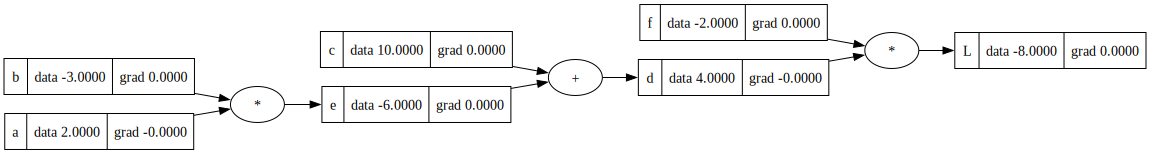

In [5]:
draw_dot(L)

### Now we want to run the backpropagation
in the backpropagation:  
We start from the end and calculate the gradient along all the intermediate values.  
We compute the derivative of each node (weights) with respect to the lost function.

We can calculate the gradient of the nodes that are connected directly to the output layer by calculating the derivative without the need of the chain rule.  


## Manual backpropagation example

In [6]:
f.grad = 4.0
d.grad = -2.0
L.grad = 1.00 # it alwayes wil be 1

### How to calculate the gradient of the lost function with respect to an intermediate value?
this is the most important step and most difficult step in the backpropagation.  

to calculate dL/dc we use the **chain rule**. because c is not directly connected to the lost function.

Chan rule: $\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx}$

In [7]:
c.grad = -2.0
e.grad = -2.0

We apply the chain rule again to find the gradient of `a` and `b`

$\frac{dL}{da} = \frac{dL}{de} * \frac{de}{da}$  

$\frac{dL}{db} = \frac{dL}{de} * \frac{de}{db}$

In [8]:
# Apply chan rule again:

# dL/de => We already have the value (-2.0)
# de/da = b => (the derivtave of multiplecation)
a.grad = -2.0 * -3.0

#dL/de = -2.0
#de/db = 2.0
b.grad = -2.0 * 2.0

In [9]:
def lol():
    h= 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label= 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    # c.data += h 
    e = a*b; e.label='e'
    d = e + c; d.label= 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1) / h)

lol()

0.0


### Preview of a single optimization step

In [10]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


### Manual backpropagation example #2: a neural

In [19]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') #6.8813735870195432
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

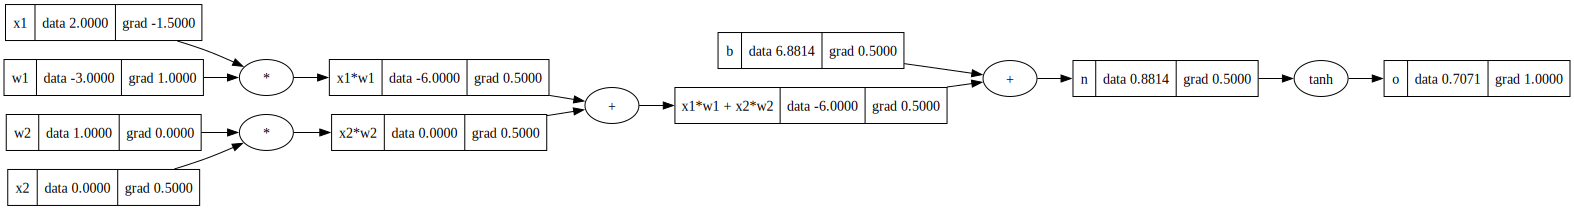

In [27]:
draw_dot(o)

### Backpropagate the neuron

0. inital gradient (node `o`):

In [21]:
o.grad = 1.0

1. First gradient (node `n`) $do/dn$:  
The local derivative of the tanh operation is:  
$do/dn = 1 - o^2$

In [22]:
n.grad = 1- o.data**2
n.grad

0.4999999999999999

2. Second gradient (node `b` and `x1*w1+x2*w2`):  
 **Plus is just a distribuotor of the gradient**
 

In [23]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

3. Third gradient (node `x2w2` and `x1w1`):  
again, plus is just a distribuotor of the gradient


In [24]:
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

4. Fourth gradient (node `x1` & `w1` and `x2` & `w2`):  
we gonna use the chain rule.  

In [25]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [26]:
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

## Automatate the backpropagation process

In [37]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') 
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

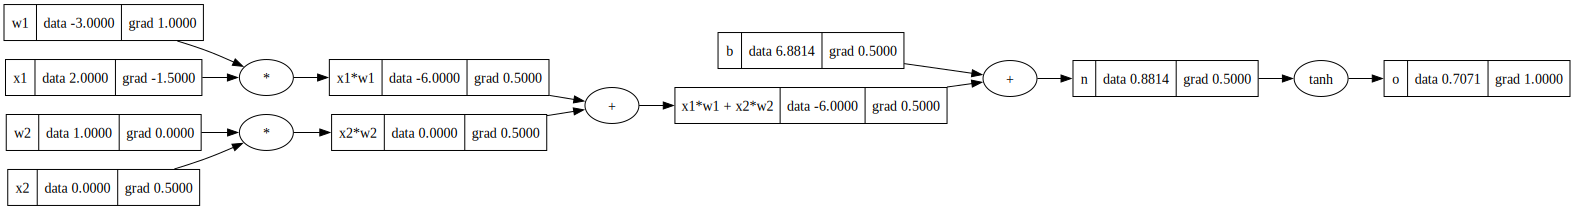

In [51]:
draw_dot(o)

In [39]:
# we just need to initialize the last node with 1
o.grad = 1.0

In [41]:
o._backward()

In [44]:
n._backward()

In [47]:
x1w1x2w2._backward()

In [49]:
x1w1._backward()
x2w2._backward()

In [50]:
x1._backward()
w1._backward()

x2._backward()
w2._backward()

## Make it fully automated using topological sort 

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') 
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

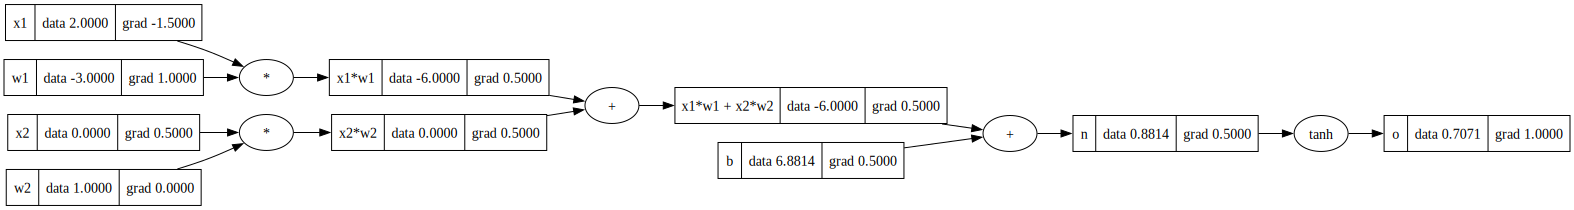

In [46]:
draw_dot(o)

In [57]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

[value(data=1.0),
 value(data=0.0),
 value(data=0.0),
 value(data=-3.0),
 value(data=2.0),
 value(data=-6.0),
 value(data=-6.0),
 value(data=6.881373587019543),
 value(data=0.8813735870195432),
 value(data=0.7071067811865476)]

In [45]:
o.backward()

### Breaking uo tanh

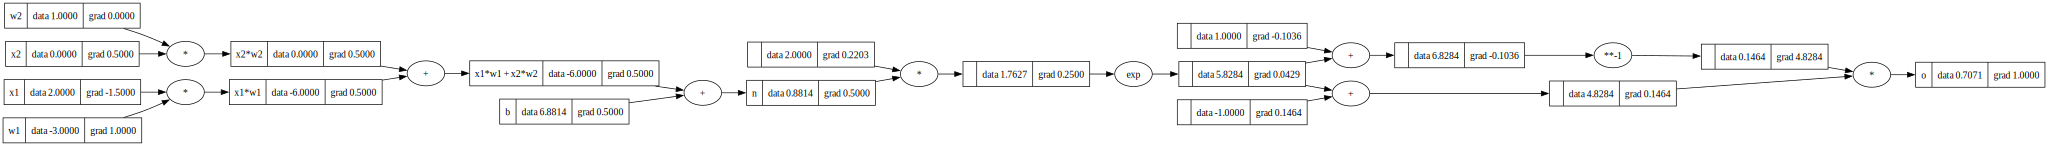

In [47]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') 
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
#----
e = (2*n).exp() 
o = (e-1) / (e+1); o.label = 'o'
#----
o.backward()
draw_dot(o)


## Rebuild it using Pytorch

In [4]:
import torch
import random

In [55]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item)
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

<built-in method item of Tensor object at 0x0000023EFE6914A0>
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [51]:
x1.item()

2.0

## Bulding a neural network (MLP)

In [5]:
class Neuron: 

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        ## We are doing a product role here
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [72]:
# example for one layer
x = [2.0, 3.0]
n = Layer(len(x), 3)
n(x)

[value(data=0.37360599672636935),
 value(data=0.9135026493875797),
 value(data=0.44129514441063145)]

In [6]:
#MLP
x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
n(x)

value(data=-0.9510492494495143)

In [7]:
# all the weights and biess
len(n.parameters())

41

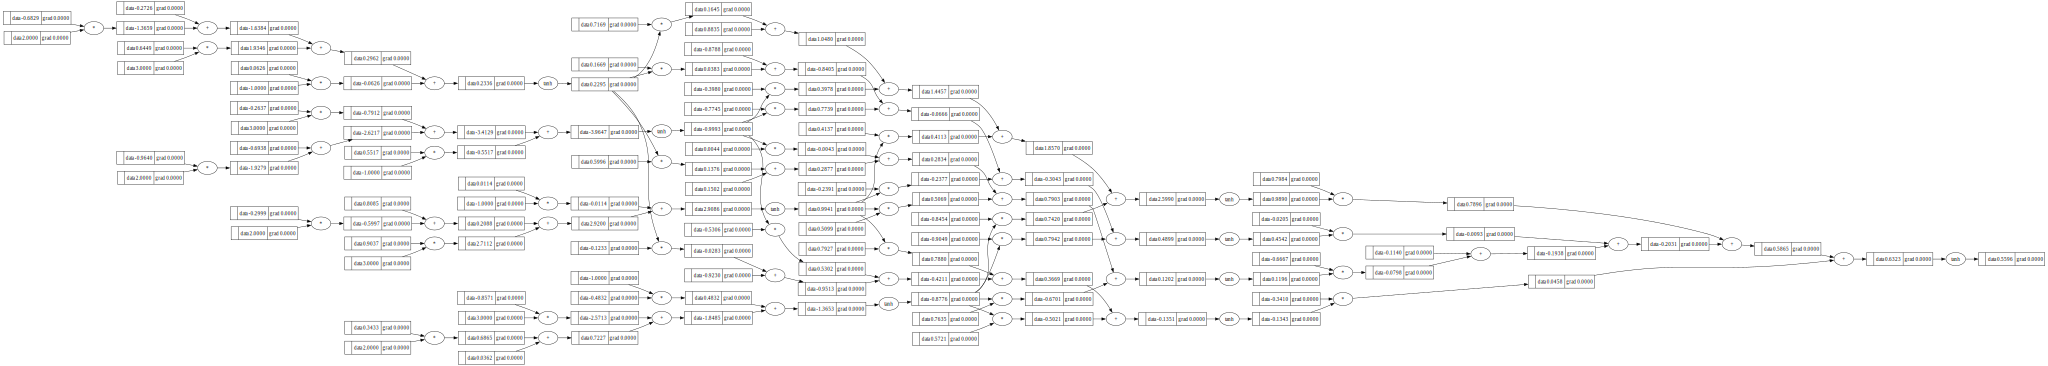

In [91]:
draw_dot(n(x))

## Example on a tiny dataset + Crearting a loss function

In [121]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[value(data=1.0),
 value(data=-0.9999999999999777),
 value(data=1.0),
 value(data=1.0)]

Creating the MSE loss function

In [10]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

value(data=8.09264497913154)

In [13]:
loss.backward()

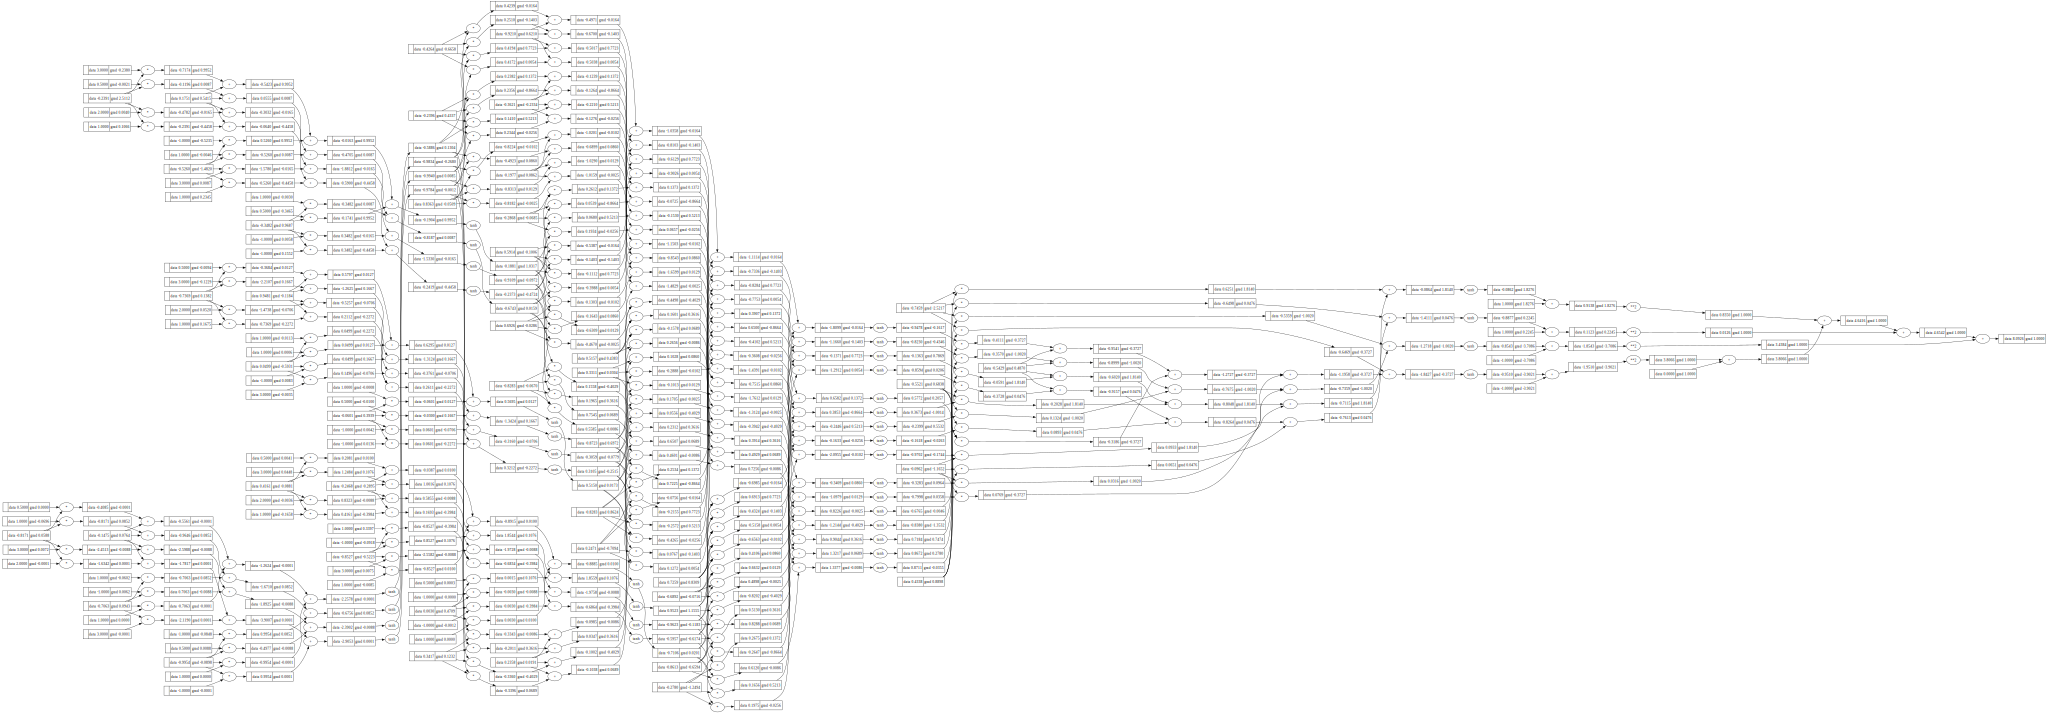

In [14]:
draw_dot(loss)

In [16]:
n.layers[0].neurons[0].w[0].data

-0.8170937527996598

In [15]:
n.layers[0].neurons[0].w[0].grad

0.05882529495914054

## Traning the network
### Doing gradient descent optimization manually  

- **the gradient is a vector that points to the direction of the increased loss.**
- In the gradient descent, we are modifying the data in the **opposite direction of the gradient** (by a small step called the learning rate.), **so we are minimizing the loss function.**


In [17]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [19]:
# to see how much the data have changed
n.layers[0].neurons[0].w[0].data

-0.8176820057492512

In [21]:
# recalculate the loss after the gradent decent iteration
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

value(data=7.858506130116953)

## Putting it all together

### Forward pass

In [123]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

value(data=4.0)

### Backward pass

In [117]:
loss.backward()

### Update the weights

In [118]:
for p in n.parameters():
    p.data += -0.05 * p.grad

## Now RELLAY put it all together

We did a mistake earlier, we didn't zero the gradients after each epoch.  
we do zero the gradients after each epoch to avoid the accumulation of the gradients.

### Initialize the network

In [128]:
x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
n(x)

value(data=-0.362080959689963)

In [131]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]

    ## calculate the loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # zero grad 
    loss.backward()

    #updating the weights
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.06391910489711562
1 0.05964540886440693
2 0.05587962556570317
3 0.05253820002177839
4 0.049554737189382775
5 0.0468758438752989
6 0.04445811801978423
7 0.042265933442906745
8 0.040269786034006654
9 0.03844504268223953
10 0.036770983395773206
11 0.03523005975236873
12 0.03380731495770054
13 0.03248992601386601
14 0.03126683913049746
15 0.030128477033840483
16 0.029066502220800643
17 0.02807362411462056
18 0.02714344094497081
19 0.026270309297860797


In [132]:
ypred

[value(data=0.941066189638862),
 value(data=-0.9280796792923299),
 value(data=-0.9039219668031165),
 value(data=0.9083834387214699)]